In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host="localhost",user = "root",password = "Sangita$1998",database = "hashcode", 
                    auth_plugin="mysql_native_password", autocommit = True)
cur = db.cursor()
cur

## List all uniques cities where customers are located


In [2]:

query = """ select distinct(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## Count the number of orders placed in 2017.


In [ ]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"total order placed in 2017 are ", data[0][0]

## Find the total sales per category.

In [6]:
query = """ select upper(products.product_category) as category, sum(payments.payment_value) as sales from products join order_items
 on products.product_id = order_items.product_id 
 join payments on payments.order_id = order_items.order_id
 group by category """
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns=['category', 'sales'])
df.head()

,category,sales
0,SPORT LEISURE,1506.379993
1,TELEPHONY,1331.990002
2,GARDEN TOOLS,546.969990
3,ELECTRONICS,788.429993
4,BABIES,395.249996


## Calculate the percentage of orders that were paid in installments.

In [7]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end)/count(*))*100 from payments"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is ",data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('100.0000'))

## Count the number of customers from each state. 

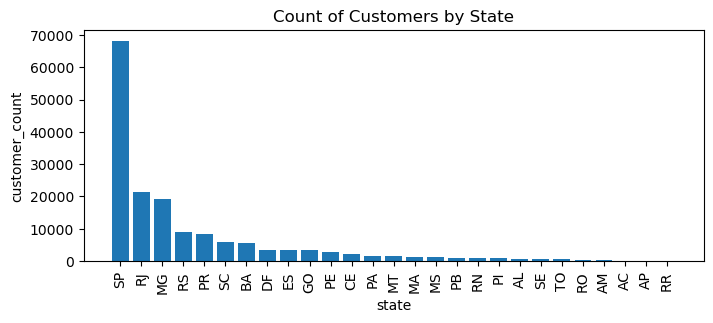

In [8]:
query = """ select customer_state, count(customer_id) from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['state','customer_count'])
df = df.sort_values(by = 'customer_count', ascending=False)
## plot increase size and reduce here
plt.figure(figsize=(8,3))
plt.bar(df['state'],df['customer_count'])
## create the rotation
plt.xticks(rotation = 90)
plt.xlabel('state')
plt.ylabel('customer_count')
plt.title('Count of Customers by State')
plt.show()

## Calculate the number of orders per month in 2018.

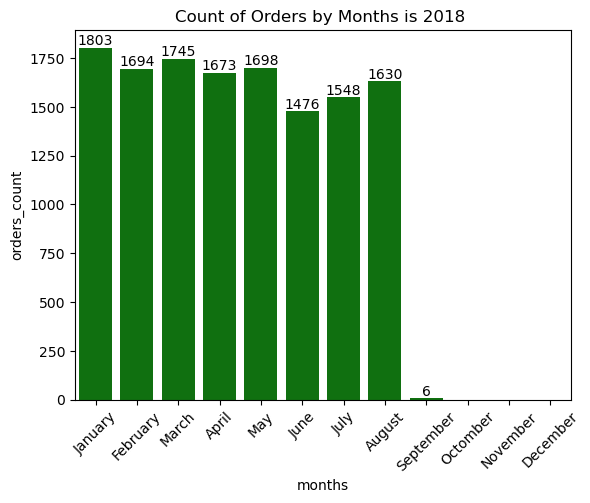

In [10]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count from orders where year(order_purchase_timestamp) = 2018
 group by months"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["months","orders_count"])
o = ["January","February","March","April","May","June","July","August","September","Octomber","November","December"]
axt = sns.barplot(x = df['months'], y = df['orders_count'], data = df, order = o, color ="green")
plt.xticks(rotation = 45)
## container use bar label
axt.bar_label(axt.containers[0])
plt.title('Count of Orders by Months is 2018 ')
plt.show()

## Find the average number of products per order, grouped by customer city

In [11]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc from orders join order_items on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

 select customers.customer_city, round(avg(count_per_order.oc),2) averge_oerders 
 from customers join count_per_order
 on customers.customer_id = count_per_order.customer_id
 group by customers.customer_city order by averge_oerders desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer city","Average orders"])
df.head(10)

,Customer city,Average orders
0,joao pessoa,3.00
1,garca,2.00
2,fortaleza,2.00
3,brusque,2.00
4,vassouras,2.00
5,resende,2.00
6,santo antonio de padua,2.00
7,sao carlos,2.00
8,patrocinio,2.00
9,itupeva,2.00


## Calculate the percentage of total revenue contributed by each product category

In [12]:
query = """ select upper(products.product_category) as category,
 round((sum(payments.payment_value)/(select sum(payment_value) from payments))* 100,2) sales_prcentage from products join order_items
 on products.product_id = order_items.product_id 
 join payments on payments.order_id = order_items.order_id
 group by category order by sales_prcentage desc """
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns=['category', 'percentage_distribution'])
df.head()

,category,percentage_distribution
0,COMPUTER ACCESSORIES,0.30
1,FURNITURE DECORATION,0.17
2,SPORT LEISURE,0.11
3,HOUSEWARES,0.11
4,TELEPHONY,0.10


## Identify the correlation between product price and the number of times a product has been purchased

In [13]:
query = """ select products.product_category, 
 count(order_items.product_id),
 avg(order_items.price) from products join order_items 
 on products.product_id = order_items.product_id 
 group by products.product_category """
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data, columns=["Category","order_count","price"])
## craete blow co-relation data
arr1 = df['order_count']
arr2 = df['price']
a = np.corrcoef([arr1, arr2])
print("he correlation between product price and the number of times a product has been purchased is", a[0][-1])

he correlation between product price and the number of times a product has been purchased is -0.14960913646089558


## Calculate the total revenue generated by each seller, and rank them by revenue

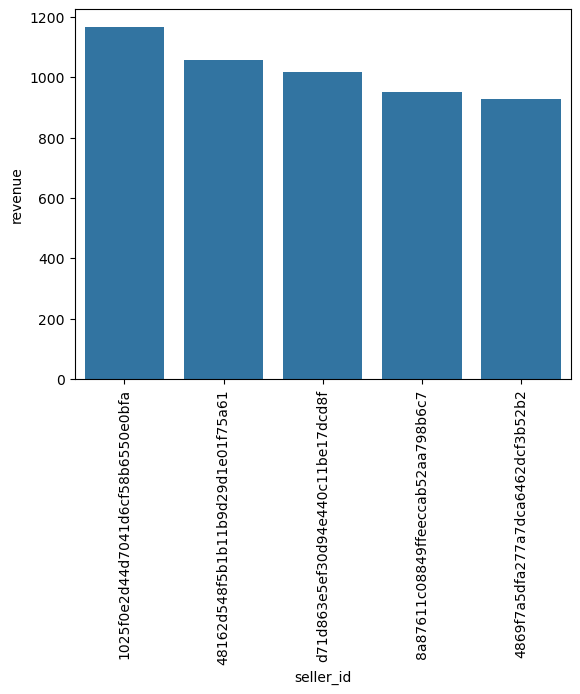

In [14]:
query = """ select * , dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, sum(payments.payment_value) revenue from order_items 
 join payments on order_items.order_id = payments.order_id
 group by order_items.seller_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['seller_id', 'revenue', 'rank'])
df = df.head()
sns.barplot(x= 'seller_id', y = 'revenue', data=df)
plt.xticks(rotation = 90)
plt.show()

##  Calculate the moving average of order values for each customer over their order history.

In [15]:
query = """ select customer_id, order_purchase_timestamp,payment, 
 avg(payment) over(partition by customer_id order by order_purchase_timestamp
 rows between 2 preceding and current row) as moving_avg from 
 (select orders.customer_id, orders.order_purchase_timestamp,
 payments.payment_value as payment from payments join orders 
 on payments.order_id = orders.order_id) as b """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,001f35d9f262c558fd065346fbf5801d,2018-01-25 17:33:55,46.53,46.529999
1,003536ce5e18f1d12b9bf76932f8a6b1,2017-10-16 19:17:54,53.33,53.330002
2,003e45472805afa1ee701d83284fa22b,2017-06-11 20:50:58,30.60,30.600000
3,0040a8417928d0d5abd5169cd7877181,2018-06-27 17:38:07,219.49,219.490005
4,0069f43bfc018147f03b7a0f64fa00bd,2018-07-19 15:51:58,75.68,75.680000
...,...,...,...,...
2072,ff92e1be6dc1bad3695547e321d2003b,2017-07-26 20:10:09,146.23,146.229996
2073,ff96b3b15e8f7a878bede85345e33f0c,2017-08-03 11:13:41,86.20,86.199997
2074,ffcdcb5ab4283658114e8077b9340a16,2018-07-03 17:32:52,47.43,47.430000
2075,ffe0aaaac429db7837e943b83ee6c385,2017-06-29 17:19:24,227.27,227.270004


## Calculate the cumulative sales per month for each year

In [16]:
query = """ select years, months, payment, sum(payment) over(order by years, months) as cumuletive_sale from
 (select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months,
 round(sum(payments.payment_value),2) payment from orders join payments 
 on orders.order_id = payments.order_id 
 group by years, months  order by years, months) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ['year', 'months', 'payment', 'cumuletive_sales'])
df

,year,months,payment,cumuletive_sales
0,2016,10,923.04,923.04
1,2017,1,1887.38,2810.42
2,2017,2,5387.03,8197.45
3,2017,3,8710.42,16907.87
4,2017,4,6986.38,23894.25
5,2017,5,13958.70,37852.95
6,2017,6,11274.58,49127.53
7,2017,7,10646.18,59773.71
8,2017,8,12498.46,72272.17
9,2017,9,14403.37,86675.54


## Calculate the year-over-year growth rate of total sales.

In [17]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
 round(sum(payments.payment_value),2) payment from orders join payments 
 on orders.order_id = payments.order_id 
 group by years  order by years) 
 select years, ((payment - lag(payment, 1) over(order by years))/lag(payment, 1) over(order by years)) * 100
  from a """
## created year-over-year growth
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['year', 'yoy % growth'])
df

,year,yoy % growth
0,2016,NaN
1,2017,15180.833983
2,2018,35.997061


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [19]:
query = """ with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
 from customers join orders
 on customers.customer_id = orders.customer_id
 group by customers.customer_id),
 b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
 from a join orders on orders.customer_id = a.customer_id
 and orders.order_purchase_timestamp > first_order
 and orders.order_purchase_timestamp < date_add(first_order, interval 18 month)
 group by a.customer_id)
 select 100 * (count( a.customer_id)/ count(distinct b.customer_id))
from a left join b on a.customer_id = b.customer_id """

cur.execute(query)
data = cur.fetchall()
"6 month purchase no data", data

('6 month purchase no data', [(None,)])

## Identify the top 3 customers who spent the most money in each year.

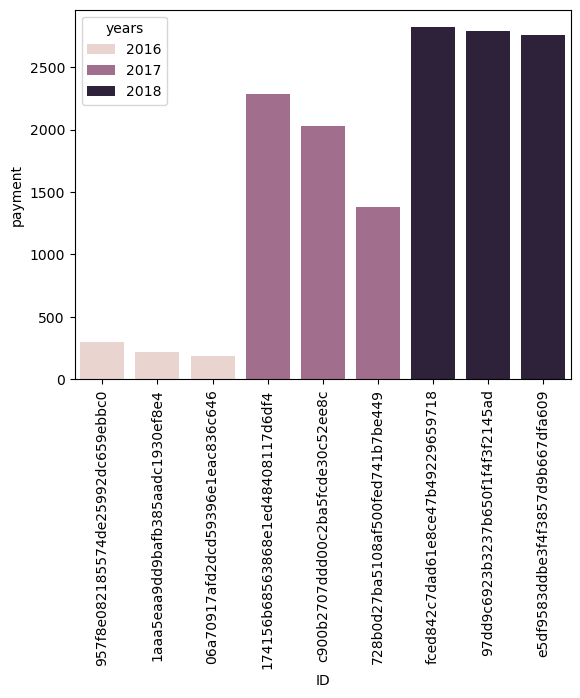

In [20]:
query = """ select years, customer_id, payment, d_rank from 
 (select year(orders.order_purchase_timestamp) years, orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over( partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) d_rank from orders join payments
on orders.order_id = payments.order_id
group by  year(orders.order_purchase_timestamp), orders.customer_id) as t
 where d_rank <= 3 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['years', 'ID', 'payment', 'rank'])
sns.barplot(x = 'ID', y= "payment", data = df, hue='years')
plt.xticks(rotation = 90)
plt.show()